# Домашнее задание 1

## Импортирование необходимых библиотек

In [1]:
from PIL import Image
from glob import glob
import time
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, Dataset, DataLoader
from torchsummary import summary
from torchvision import transforms as T
from tensorflow import summary as tfsummary
import pickle
from sklearn.metrics import classification_report
from PIL import Image
from tqdm.auto import tqdm
from IPython.display import clear_output
import matplotlib.pyplot as plt
import os
%matplotlib inline
%load_ext tensorboard

2024-03-20 17:54:14.311035: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-20 17:54:17.881854: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-20 17:54:45.866573: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/artyom/VUZ_Learning/DLIU/venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [3]:
!nvidia-smi

Wed Mar 20 17:55:02 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.161.07             Driver Version: 535.161.07   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce GTX 1050        Off | 00000000:01:00.0 Off |                  N/A |
| N/A   51C    P8              N/A /  38W |     99MiB /  2048MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Чтение тренировочной и тестовой выборки

Инструкция для скачивания и загрузки фотографий в Сolab находится в github

In [4]:
heigth_width = 32

CLASSES = ['Бледная поганка', 'Мухомор', 'Подосиновик'] # Здесь требуется указать ваши классы

images = []
images_t = []
classes = []
classes_t = []

for CLASS in range(0, len(CLASSES)):
  path_class_1 = "./images/%s/*.*"%CLASSES[CLASS]
  i=0
  for photo in glob(path_class_1):
      i+=1
      img = Image.open(photo).convert('RGB')
      img = img.resize((heigth_width, heigth_width), Image.ANTIALIAS)
      if i > int(len(os.listdir("./images/%s/"%CLASSES[CLASS]))*0.8):
          images_t.append(np.asarray(img))
          classes_t.append(np.asarray(CLASS))
      else:
          images.append(np.asarray(img))
          classes.append(np.asarray(CLASS))


train_X = np.array(images)
train_y = np.array(classes)

test_X = np.array(images_t)
test_y = np.array(classes_t)

/tmp/ipykernel_180104/3561612303.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = img.resize((heigth_width, heigth_width), Image.ANTIALIAS)


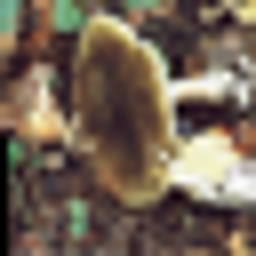

In [ ]:
class CifarDataset(Dataset):
     def __init__(self, X, y, transform=None, p=0.0):
         assert X.size(0) == y.size(0)
         super(Dataset, self).__init__()
         self.X = X
         self.y = y
         self.transform = transform
         self.prob = p
        
     def __len__(self):
         return self.y.size(0)
        
     def __getitem__(self, index):
        x = self.X[index]
        if self.transform and np.random.random()<self.prob:
            x = self.transform(x.permute(2, 0, 1)/255.).permute(1, 2, 0)*255.
        y = self.y[index]
        return x, y

transform = T.Compose([
     T.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.2, hue=0.0),
     T.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.8, 1.2),
                    shear=5),
])
#transform = T.AutoAugment(T.AutoAugmentPolicy.CIFAR10)

Image.fromarray((transform(torch.Tensor(train_X[50]).permute(2, 0, 1)/255.).\
                 permute(1, 2, 0).numpy()*255.).astype(np.uint8)).\
                 resize((256, 256))

###Приведение фотографий к требуемому размеру

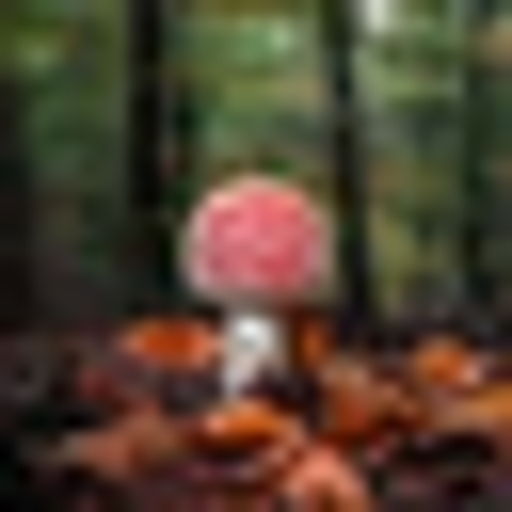

In [ ]:
Image.fromarray(train_X[123]).resize((512,512))

##Создание Pytorch DataLoader'a

In [ ]:
batch_size = 32
dataloader = {}
for (X, y), part in zip([(train_X, train_y), (test_X, test_y)],
                        ['train', 'test']):
    tensor_x = torch.Tensor(X)
    tensor_y = F.one_hot(torch.Tensor(y).to(torch.int64),
                                     num_classes=len(CLASSES))/1.
    dataset = CifarDataset(tensor_x, tensor_y,
                           transform if part=='train' else None,
                           p=0.5) # создание объекта датасета
    dataloader[part] = DataLoader(dataset, batch_size=batch_size,
                                  prefetch_factor=8 if part=='train' else 2,
                                  num_workers=2, persistent_workers=True,
                                  shuffle=True) # создание экземпляра класса DataLoader
dataloader

{'train': <torch.utils.data.dataloader.DataLoader at 0x7f54a7038a00>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x7f539034c520>}

##Создание Pytorch модели многослойного перцептрона с одним скрытым слоем

In [ ]:
class Normalize(nn.Module):
    def __init__(self, mean, std):
        super(Normalize, self).__init__()
        self.mean = torch.tensor(mean).to(device)
        self.std = torch.tensor(std).to(device)

    def forward(self, input):
        x = input / 255.0
        x = x - self.mean
        x = x / self.std
        return x.permute(0, 3, 1, 2) # nhwc -> nm

class GlobalMaxPool2d(nn.Module):
    def __init__(self):
        super(GlobalMaxPool2d, self).__init__()

    def forward(self, input):
        out = F.adaptive_max_pool2d(input, output_size=1)
        return out.flatten(start_dim=1)

class Cifar100_CNN(nn.Module):
    def __init__(self, hidden_size=32, classes=100):
        super(Cifar100_CNN, self).__init__()
        # https://blog.jovian.ai/image-classification-of-cifar100-dataset-using-pytorch-8b7145242df1
        self.seq = nn.Sequential(
            Normalize([0.5074,0.4867,0.4411],[0.2011,0.1987,0.2025]),
            # первый способ уменьшения размерности картинки - через stride
            nn.Conv2d(3, HIDDEN_SIZE, 5, stride=4, padding=2),
            nn.ReLU(),
            nn.Dropout2d(p=0.1),
            # второй способ уменьшения размерности картинки - через слой пуллинг
            nn.Conv2d(HIDDEN_SIZE, HIDDEN_SIZE*2, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.AvgPool2d(4),
            nn.Dropout2d(p=0.1),
            # nn.MaxPool2d(4),
            nn.Flatten(),
            nn.Linear(HIDDEN_SIZE*8, classes),
        )

    def forward(self, input):
        return self.seq(input)

HIDDEN_SIZE = 32 # в 4 раза больше параметров, чем у свёрточной модели из ЛР2 
model = Cifar100_CNN(hidden_size=HIDDEN_SIZE, classes=len(CLASSES))
# NEW
model.to(device)
print(model(torch.rand(1, 32, 32, 3).to(device)))
summary(model, input_size=(32, 32, 3))
model

tensor([[ 0.0182, -0.1403,  0.0809]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         Normalize-1            [-1, 3, 32, 32]               0
            Conv2d-2             [-1, 32, 8, 8]           2,432
              ReLU-3             [-1, 32, 8, 8]               0
         Dropout2d-4             [-1, 32, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]          18,496
              ReLU-6             [-1, 64, 8, 8]               0
         AvgPool2d-7             [-1, 64, 2, 2]               0
         Dropout2d-8             [-1, 64, 2, 2]               0
           Flatten-9                  [-1, 256]               0
           Linear-10                    [-1, 3]             771
Total params: 21,699
Trainable params: 21,699
Non-trainable params: 0
----------------------------------------------------------------
Input si

Cifar100_CNN(
  (seq): Sequential(
    (0): Normalize()
    (1): Conv2d(3, 32, kernel_size=(5, 5), stride=(4, 4), padding=(2, 2))
    (2): ReLU()
    (3): Dropout2d(p=0.1, inplace=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): AvgPool2d(kernel_size=4, stride=4, padding=0)
    (7): Dropout2d(p=0.1, inplace=False)
    (8): Flatten(start_dim=1, end_dim=-1)
    (9): Linear(in_features=256, out_features=3, bias=True)
  )
)

##Выбор функции потерь и оптимизатора градиентного спуска

In [ ]:
# добавляем сглаживание целевых меток, это увеличит значение функции потерь
# но полученная модель будет более устойчивой к выбросам в обучающей выборке
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
# используется SGD c momentum и L2-регуляризацией весов
optimizer = optim.SGD(model.parameters(), lr=3e-3, momentum=0.9,
                      weight_decay=1e-5)
# добавляем постепенное уменьшение шага обучения каждые 200 эпох
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=240, gamma=0.5)

In [ ]:
%tensorboard --logdir logs/tensorboard

Launching TensorBoard...

##Обучение модели по эпохам

In [ ]:
EPOCHS = 250
steps_per_epoch = len(dataloader['train'])
steps_per_epoch_val = len(dataloader['test'])
for epoch in range(EPOCHS):  # проход по набору данных несколько раз
    running_loss = 0.0
    model.train()
    for i, batch in enumerate(dataloader['train'], 0):
        # получение одного минибатча; batch это двуэлементный список из [inputs, labels]
        inputs, labels = batch

        # очищение прошлых градиентов с прошлой итерации
        optimizer.zero_grad()

        # прямой + обратный проходы + оптимизация
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        #loss = F.cross_entropy(outputs, labels)
        loss.backward()
        optimizer.step()

        # для подсчёта статистик
        running_loss += loss.item()
    print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / steps_per_epoch:.3f}')
    running_loss = 0.0
    model.eval()
    with torch.no_grad(): # отключение автоматического дифференцирования
        for i, data in enumerate(dataloader['test'], 0):
            inputs, labels = data

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
    print(f'[{epoch + 1}, {i + 1:5d}] val loss: {running_loss / steps_per_epoch_val:.3f}')
print('Обучение закончено')

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu!

##Проверка качества модели по классам на обучающей и тестовой выборках

In [ ]:
for part in ['train', 'test']:
    y_pred = []
    y_true = []
    with torch.no_grad(): # отключение автоматического дифференцирования
        for i, data in enumerate(dataloader[part], 0):
            inputs, labels = data

            outputs = model(inputs).detach().numpy()
            y_pred.append(outputs)
            y_true.append(labels.numpy())
        y_true = np.concatenate(y_true)
        y_pred = np.concatenate(y_pred)
        print(part)
        print(classification_report(y_true.argmax(axis=-1), y_pred.argmax(axis=-1),
                                    digits=4, target_names=list(map(str, CLASSES))))
        print('-'*50)

train
                 precision    recall  f1-score   support

Бледная поганка     1.0000    1.0000    1.0000        83
        Мухомор     1.0000    1.0000    1.0000        88
    Подосиновик     1.0000    1.0000    1.0000        84

       accuracy                         1.0000       255
      macro avg     1.0000    1.0000    1.0000       255
   weighted avg     1.0000    1.0000    1.0000       255

--------------------------------------------------
test
                 precision    recall  f1-score   support

Бледная поганка     0.7083    0.8095    0.7556        21
        Мухомор     0.7222    0.5909    0.6500        22
    Подосиновик     0.5909    0.6190    0.6047        21

       accuracy                         0.6719        64
      macro avg     0.6738    0.6732    0.6701        64
   weighted avg     0.6746    0.6719    0.6698        64

--------------------------------------------------


##Сохранение модели в ONNX

In [ ]:
# # сохраниение модели
# # ПЕРВЫЙ СПОСОБ: сохранение параметров
# PATH = 'cifar.pth'
# torch.save(model.state_dict(), PATH)
# # загрузка
# new_model = Cifar100_MLP(hidden_size=HIDDEN_SIZE, classes=len(CLASSES))
# new_model.load_state_dict(torch.load(PATH))
# new_model.eval()

# # ВТОРОЙ СПОСОБ: сохранение всей архитектуры
# PATH2 = 'cifar.pt'
# torch.save(model, PATH2)
# # загрузка
# new_model_2 = torch.load(PATH2)
# new_model_2.eval()

Cifar100_MLP(
  (norm): Normalize()
  (seq): Sequential(
    (0): Linear(in_features=3072, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=3, bias=True)
  )
)

In [ ]:
# # входной тензор для модели
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# x = torch.randn(1, 32, 32, 3, requires_grad=True).to(device)
# torch_out = model(x)

# # экспорт модели
# torch.onnx.export(model,               # модель
#                   x,                   # входной тензор (или кортеж нескольких тензоров)
#                   "cifar100.onnx", # куда сохранить (либо путь к файлу либо fileObject)
#                   export_params=True,  # сохраняет веса обученных параметров внутри файла модели
#                   opset_version=9,     # версия ONNX
#                   do_constant_folding=True,  # следует ли выполнять укорачивание констант для оптимизации
#                   input_names = ['input'],   # имя входного слоя
#                   output_names = ['output'],  # имя выходного слоя
#                   dynamic_axes={'input' : {0 : 'batch_size'},    # динамичные оси, в данном случае только размер пакета
#                                 'output' : {0 : 'batch_size'}})